#**A Study in Natural Language Processing: Text Summarization**

##Introduction

Problem Statement

> Today we live in an age of mass information, where it is easier than ever to access all sorts of information through online news articles, social media, and books. One of the problems we have in today’s age of “clickbait” headlines and catchy titles is that a good portion of readers don’t read the full article anymore. Or they go straight to SparkNotes instead of reading the book. Or maybe they just look at the star rating of a review instead of reading the full review for any nuance.

> With that said, it is understandable that no one can read every article, book, or review they come across, as there is almost an overload of information through television, social media, and the internet.

Solution

> What this project seeks to solve is that problem: creating a simple text summarizer that can generate a good summary from a larger text. In this way, if one is pressed for time, or wants a good summary of information for any particle article, they can use the text summarization algorithm to handle all of the work that comes with creating a summary.

There are two types of text summarizations, as defined below:

> Extractive:

>> This method selects a subset of words that seeks to retain the most important points of the larger text. It weighs the most important parts of the sentences in the text and then forms the summary based on those most important features. This is the method I will be working with for this model.

> Abstractive:

>> This method is newer and less used than extractive. It selects words based on semantic understanding and attempts to produce material in new ways. It uses deep learning techniques to generate shorter texts that convey the most important parts of the original text.



##Installing and Importing Data

To begin, I'll need to install the first few libraries I need to compmlete the capstone. For the following project, I'll be trying to summarize the Universal Declaration of Human Rights Corpus from the NLTK corpus. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import udhr
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from time import time
import networkx
import re
import heapq
import spacy
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('udhr')
nltk.download('stopwords')
nltk.download('wordnet')

!python -m spacy download en

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package udhr to /root/nltk_data...
[nltk_data]   Unzipping corpora/udhr.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


#Text Preprocessing

Now that the corpus is downloaded, we can dig in to look at it and clean things up.

In [ ]:
# grab and process the raw data
print(udhr.fileids())

udhr_raw = udhr.raw('English-Latin1')

# print the first 100 characters of the Universal Declaration of Human Rights
print('\nRaw:\n', udhr_raw[0:])

['Abkhaz-Cyrillic+Abkh', 'Abkhaz-UTF8', 'Achehnese-Latin1', 'Achuar-Shiwiar-Latin1', 'Adja-UTF8', 'Afaan_Oromo_Oromiffa-Latin1', 'Afrikaans-Latin1', 'Aguaruna-Latin1', 'Akuapem_Twi-UTF8', 'Albanian_Shqip-Latin1', 'Amahuaca', 'Amahuaca-Latin1', 'Amarakaeri-Latin1', 'Amuesha-Yanesha-UTF8', 'Arabela-Latin1', 'Arabic_Alarabia-Arabic', 'Asante-UTF8', 'Ashaninca-Latin1', 'Asheninca-Latin1', 'Asturian_Bable-Latin1', 'Aymara-Latin1', 'Balinese-Latin1', 'Bambara-UTF8', 'Baoule-UTF8', 'Basque_Euskara-Latin1', 'Batonu_Bariba-UTF8', 'Belorus_Belaruski-Cyrillic', 'Belorus_Belaruski-UTF8', 'Bemba-Latin1', 'Bengali-UTF8', 'Beti-UTF8', 'Bichelamar-Latin1', 'Bikol_Bicolano-Latin1', 'Bora-Latin1', 'Bosnian_Bosanski-Cyrillic', 'Bosnian_Bosanski-Latin2', 'Bosnian_Bosanski-UTF8', 'Breton-Latin1', 'Bugisnese-Latin1', 'Bulgarian_Balgarski-Cyrillic', 'Bulgarian_Balgarski-UTF8', 'Cakchiquel-Latin1', 'Campa_Pajonalino-Latin1', 'Candoshi-Shapra-Latin1', 'Caquinte-Latin1', 'Cashibo-Cacataibo-Latin1', 'Cashinahua-

Looks good! Before really getting into anything, it is good practice to perform some basic text cleaning. 

In [ ]:
# For this text, let's remove the article headings
udhr_raw = re.sub(r'Article \d+', '',udhr_raw)

print('With article headings removed:',udhr_raw[0:300])

With article headings removed: Universal Declaration of Human Rights
Preamble
Whereas recognition of the inherent dignity and of the equal and inalienable rights of all members of the human family is the foundation of freedom, justice and peace in the world, 

Whereas disregard and contempt for human rights have resulted in barba


In [ ]:
# remove newlines and other extra whitespace by splitting and rejoining
udhr_raw = ' '.join(udhr_raw.split())

# all done with cleanup? let's see how it looks.
print('Extra whitespace removed:', udhr_raw[0:500])

Extra whitespace removed: Universal Declaration of Human Rights Preamble Whereas recognition of the inherent dignity and of the equal and inalienable rights of all members of the human family is the foundation of freedom, justice and peace in the world, Whereas disregard and contempt for human rights have resulted in barbarous acts which have outraged the conscience of mankind, and the advent of a world in which human beings shall enjoy freedom of speech and belief and freedom from fear and want has been proclaimed as th


##Tokenization

Now that we have performed some basic text cleaning, the next step is tokenization. Tokenization breaks up the text into pieces, which allows us to later generate numerical representations of the text from the created tokens. We'll let spaCy do all of the work for us.

In [ ]:
nlp = spacy.load('en')

# all processing work is done below
udhr_doc = nlp(udhr_raw)

Now our parsed text is stored into two variables. Before moving on, let's take a look at what everything is, exactly.

In [ ]:
# let's explore the objects we've built.
print("The udhr_doc object is a {} object.".format(type(udhr_doc)))
print("It is {} tokens long".format(len(udhr_doc)))
print("The first three tokens are '{}'".format(udhr_doc[:3]))
print("The type of each token is {}".format(type(udhr_doc[0])))

The udhr_doc object is a <class 'spacy.tokens.doc.Doc'> object.
It is 1723 tokens long
The first three tokens are 'Universal Declaration of'
The type of each token is <class 'spacy.tokens.token.Token'>


##Remove stopwords

After tokenization, we remove the stopwords. These are the words that occur a lot in a text and convey little meaning. This helps to get rid of noisy data, and reduces the size of the text and future computation.

In [ ]:
udhr_without_stopwords = [token for token in udhr_doc if not token.is_stop]

Now we have our tokens stored in a list without stop words. We can take a quick look at how frequent each token shows up in our corpus. We'll also take a look at the most common tokens with a graphical visualization.

In [ ]:
# utility function to calculate how frequently words appear in the text
def word_frequencies(text):
    
    # build a list of words
    # strip out punctuation
    words = []
    for token in text:
        if not token.is_punct:
            words.append(token.text)
            
    # build and return a Counter object containing word counts
    return Counter(words)

# instantiate our list of most common words.
udhr_word_freq = word_frequencies(udhr_without_stopwords).most_common(10)
print('Universal Declaration of Human Rights:', udhr_word_freq)

Universal Declaration of Human Rights: [('right', 32), ('shall', 26), ('rights', 16), ('equal', 11), ('human', 11), ('freedom', 11), ('entitled', 9), ('protection', 9), ('law', 8), ('social', 8)]


##Lemmatization

As we can see above, while tokenization is great, we have words like 'right' and 'rights' making the most frequent list. These words are related, and by performing lemmatization, we can further remove some noise from the corpus by reducing each word to its root, or lemma. In this way, we'll be building a count of *concepts*, not just *words*.

In [ ]:
# utility function to calculate how frequently lemas appear in the text
def lemma_frequencies(text):
    
    # build a list of lemas
    # strip out punctuation
    lemmas = []
    for token in text:
        if not token.is_punct:
            lemmas.append(token.lemma_)
            
    # build and return a Counter object containing lemma counts
    return Counter(lemmas)

# instantiate our list of most common lemmas
udhr_lemma_freq = lemma_frequencies(udhr_without_stopwords).most_common(10)
print('UDHR:', udhr_lemma_freq)

UDHR: [('right', 48), ('shall', 26), ('freedom', 17), ('equal', 11), ('human', 11), ('entitle', 9), ('protection', 9), ('law', 8), ('social', 8), ('education', 8)]


#Text Visualizations (N-grams, Word Cloud)

Now, we have what we need to move on. However, it is important to visualize our data, so before moving on, I'll plot the text data that conveys the above information. It's especially important to visualize just *how* important some of the words are in the text. This will create an accurate image in our heads for how our summarized sentences will end up looking like.

In [ ]:
# First, we'll group into sentences
udhr_sents = [[sent] for sent in udhr_doc.sents]

# Create a DataFrame for the sentences
sentences = pd.DataFrame(udhr_sents, columns = ['text'])
sentences.head()

,text
0,"(Universal, Declaration, of)"
1,"(Human, Rights, Preamble, Whereas, recognition..."
2,"(All, human, beings, are, born, free, and, equ..."
3,"(They, are, endowed, with, reason, and, consci..."
4,"(Everyone, is, entitled, to, all, the, rights,..."


In [ ]:
# Remove stop words and punctuation and lemmatize the tokens

for i, sentence in enumerate(sentences['text']):
  sentences.loc[i, 'text'] = " ".join(
      [token.lemma_ for token in sentence if not token.is_punct and not token.is_stop])

In [ ]:
sentences.head()

,text
0,Universal Declaration
1,Human Rights Preamble recognition inherent dig...
2,human being bear free equal dignity right
3,endow reason conscience act spirit brotherhood
4,entitle right freedom set forth Declaration di...


In [ ]:
import unicodedata

def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [ ]:
words = basic_clean(''.join(str(sentences['text'].tolist())))

Using our list of words, excluding stopwords, let's look at the different N-grams in the text.

**N-gram = 1**

In [ ]:
unigram = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:10]
unigram

(right,)         50
(shall,)         26
(freedom,)       17
(human,)         13
(equal,)         11
(entitle,)        9
(protection,)     9
(education,)      8
(social,)         8
(law,)            8
dtype: int64

Here we can see that this confirms our earlier inquiry into the frequency of words we gathered from our earlier lemmatization. However, this time we took into account capitalization and normalized all of our words, which changed the frequency slightly, with words like "human" and "right" getting a boost. 

**N-gram = 2**

In [ ]:
bigram = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
bigram

(right, freedom)        8
(human, right)          7
(education, shall)      6
(united, nation)        4
(penal, offence)        4
(shall, hold)           3
(shall, subject)        3
(right, fundamental)    2
(man, woman)            2
(right, protection)     2
dtype: int64

**Visualization**

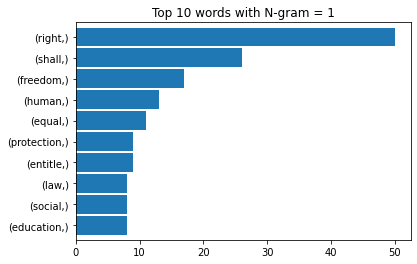

In [ ]:
unigram.sort_values().plot.barh(width=.9)
plt.title('Top 10 words with N-gram = 1')
plt.show()

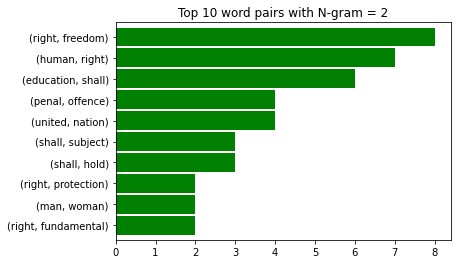

In [ ]:
bigram.sort_values().plot.barh(color='green', width=.9)
plt.title('Top 10 word pairs with N-gram = 2')
plt.show()

As we can see, words like "right", "human" and "education" feature heavily into our data exploration. With the following WordCloud, we will be able to see an amazing representation of the unigram results, plus other words outside of the top ten.

**Word Cloud**

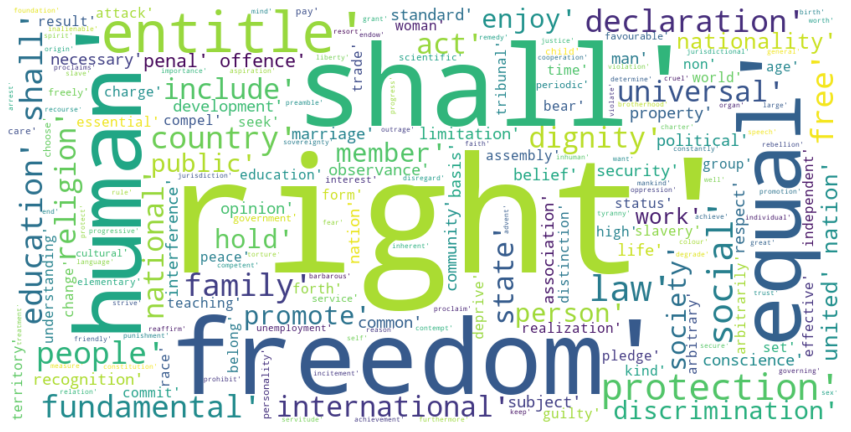

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000,height=500,background_color='white').generate(str(words))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Beautiful! It doesn't give any new information, but it does help reveal how our text summarization will handle the words when creating a summary.

#Text Summarizer (GloVe)

For our first attempt, we'll build it from the ground up again, using the NLTK libraries and Gensim algorithms (TextRank). From seeing the lemmatization, n-gram graphs, and word cloud we have a general idea on what the corpus summary should emphasize: rights, freedom, equality, education, etc.

At the end, if our summary appears to emphasizes these topics, we know that our text summarizer is doing a good job.

In [ ]:
# Here, we'll be able to generate clean sentences from articles pulled from online

sentences = list(udhr_doc.sents)
print('The Universal Declaration of Human Rights has {} sentences.'.format(len(sentences)))

print(sentences)

The Universal Declaration of Human Rights has 59 sentences.
[Universal Declaration of, Human Rights Preamble Whereas recognition of the inherent dignity and of the equal and inalienable rights of all members of the human family is the foundation of freedom, justice and peace in the world, Whereas disregard and contempt for human rights have resulted in barbarous acts which have outraged the conscience of mankind, and the advent of a world in which human beings shall enjoy freedom of speech and belief and freedom from fear and want has been proclaimed as the highest aspiration of the common people, Whereas it is essential, if man is not to be compelled to have recourse, as a last resort, to rebellion against tyranny and oppression, that human rights should be protected by the rule of law, Whereas it is essential to promote the development of friendly relations between nations, Whereas the peoples of the United Nations have in the Charter reaffirmed their faith in fundamental human right

For this project, I'll be using **GloVe** Word Embeddings. This was briefing talked about in the NLP Thinkful Module as something to research on my own, so I'll be attempting to use it here. I could have used Bag of Words or Tf-IDF approaches to create features, but those methods ignore the order of the words. 

Next, I'll use the pre-trained GloVe vectors.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-09-21 13:29:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-21 13:29:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-21 13:29:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

Here, we'll extract the word vectors 

**Vector Representation of Sentences**

In [ ]:
word_vectors = {}

f = open('glove.6B.100d.txt', encoding='utf-8')

for line in f:
  values = line.split()
  word = values[0]
  coeffs = np.asarray(values[1:], dtype='float32')
  word_vectors[word] = coeffs
f.close()


In [ ]:
len(word_vectors)

400000

Sweet, now we have word vectors for 400,000 different terms stored in our dictionary. Next we'll create vectors for the sentences. What is happening here is that we first fetch vectors for the words in a sentence and then take the mean of the vectors to get a merged vector for the sentence.

In [ ]:
# Transform our sentences into a pandas dataframe
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

In [ ]:
# Transform the dataframe into a string
clean_sentences=clean_sentences.astype(str)

In [ ]:
sent_vectors = []

for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_vectors.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sent_vectors.append(v)

**Similarity Matrix Preparation**

Here, we will have to find similarities between the sentences, and then use cosine similarity to approach the problem. Starting with a new matrix, we'll use cosine similarity to fill in the matrix with the cosine similarities of the sentences.

In the following code, *n* is the number of sentences.

In [ ]:
# Initialize our matrix with (n * n)
cos_sim_matrix = np.zeros([len(sentences), len(sentences)])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      cos_sim_matrix[i][j] = cosine_similarity(sent_vectors[i].reshape(1,100),sent_vectors[j].reshape(1,100))[0,0]

Now that we have our matrix, we can use the TextRank Algorithm. We convert the matrix into a "graph", and the nodes of the graph represent the sentences, while the edges represent the cosine similarity scores between each sentence. 

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_array(cos_sim_matrix)
scores = nx.pagerank(nx_graph)

#Summary Extraction

Here we will extract the top sentences based on the scores from the summary generation.

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
topsen = 10

for i in range(topsen):
  print(ranked_sentences[i][1])

Everyone has duties to the community in which alone th
Everyone is entitled to a social and international order in which the rights and freedoms set forth in this Declaration can be fully realized.
Everyone has the right to the protection of the moral and material interests resulting from any scientific, literary or artistic production of which he is the author.
Everyone has the right freely to participate in the cultural life of the community, to enjoy the arts and to share in scientific advancement and its benefits.
Parents have a prior right to choose the kind of education that shall be given to their children.
It shall promote understanding, tolerance and friendship among all nations, racial or religious groups, and shall further the activities of the United Nations for the maintenance of peace.
Education shall be directed to the full development of the human personality and to the strengthening of respect for human rights and fundamental freedoms.
Technical and professional educat

#Gensim Summarizer (Automatic)

For comparison purposes, we'll use the Gensim summarizer to train our corpus to see how it compares to the manual summarizer. The methods are going to be very similar, as both use Gensim algorithms, but we'll see how the actual gesim summarization algorithm performs.

In [ ]:
pip install lxml

In [ ]:
import bs4 as bs 
import urllib.request
import pprint
pp = pprint.PrettyPrinter(indent=4)
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s', level=logging.INFO)
from gensim.summarization import summarize
from gensim.summarization import keywords

url = input('Enter link to pull: ')

scraped_data = urllib.request.urlopen(url)
article = scraped_data.read()

parse_article = bs.BeautifulSoup(article,'lxml')

paragraphs = parse_article.find_all('p')

text = ''

for p in paragraphs:
  text += p.text

print()
print("SUMMARY:")
print()
pp.pprint(summarize(text,ratio=0.05))
print()
print("KEYWORDS:")
print()
print(keywords(text,ratio=0.05))

# COPY THIS LINK TO TRAIN MODEL ON DATA USED IN THIS PROJECT:

# https://raw.githubusercontent.com/NehemiahSolis/Text-Summarization-A-Study-in-Natural-Language-Processing/master/UDHR_eng.txt


2020-09-21 13:36:33,003 INFO : 'pattern' package not found; tag filters are not available for English


Enter link to pull: https://raw.githubusercontent.com/NehemiahSolis/Text-Summarization-A-Study-in-Natural-Language-Processing/master/UDHR_eng.txt


2020-09-21 13:36:40,187 INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-09-21 13:36:40,192 INFO : built Dictionary(350 unique tokens: ['declar', 'human', 'right', 'univers', 'preambl']...) from 101 documents (total 799 corpus positions)



SUMMARY:

('Whereas the peoples of the United Nations have in the Charter reaffirmed '
 'their faith in fundamental human rights, in the dignity and worth of the '
 'human person and in the equal rights of men and women and have determined to '
 'promote social progress and better standards of life in larger freedom,\r\n'
 'Whereas Member States have pledged themselves to achieve, in co‐operation '
 'with the United Nations, the promotion of universal respect for and '
 'observance of human rights and fundamental freedoms,\r\n'
 'Proclaims this Universal Declaration of Human Rights as a common standard of '
 'achievement for all peoples and all nations, to the end that every '
 'individual and every organ of society, keeping this Declaration constantly '
 'in mind, shall strive by teaching and education to promote respect for these '
 'rights and freedoms and by progressive measures, national and international, '
 'to secure their universal and effective recognition and observance, bo

#Creating a Functional User Interface
 

Using pywidgets, I was able to make a quick little widget that outputted the same information as above, but in a more user friendly manner.

Source: "Data Scientist's Guide to Summarization" by Richa Bathija

In [ ]:
# COPY THIS LINK TO TRAIN MODEL ON DATA USED IN THIS PROJECT:

# https://raw.githubusercontent.com/NehemiahSolis/Text-Summarization-A-Study-in-Natural-Language-Processing/master/UDHR_eng.txt

from ipywidgets import widgets, interact, interact_manual

def Run_Txt_Summary():

  url_link = url.value
  shrinkval = float(str(shrink.value))
  model = output_model.value

  if model == 'Gensim Using Text Rank':

    scraped_data = urllib.request.urlopen(url_link)
    article = scraped_data.read()

    parsed_text = bs.BeautifulSoup(article, 'lxml')

    paragraphs = parsed_text.find_all('p')

    text = ''

    for p in paragraphs:
      text += p.text
    
    print()
    print("SUMMARY:")
    print()
    pp.pprint(summarize(text,ratio=shrinkval))
    print()
    print("KEYWORDS:")
    print()
    print(keywords(text,ratio=shrinkval))



In [ ]:
def f(Model):
    output_model.value = str(Model)

print("Choose the model you want to use")
output_model = widgets.Text()
interact(f, Model=['Gensim Using Text Rank'])
url=widgets.Text()
display("Enter the Link",url)

shrink = widgets.Text()
display("Enter the Shrink Ratio", shrink)

interact_manual.opts['manual_name'] = 'Run'
bt = interact_manual(Run_Txt_Summary)

Choose the model you want to use


interactive(children=(Dropdown(description='Model', options=('Gensim Using Text Rank',), value='Gensim Using T…

'Enter the Link'

Text(value='')

'Enter the Shrink Ratio'

Text(value='')

interactive(children=(Button(description='Run', style=ButtonStyle()), Output()), _dom_classes=('widget-interac…

#Conclusion

Natural Language Processing is a vast and interesting field with many challenges. In this project, I attempted to create a simple text summarizer with Gensim and NLTK libraries, using the extractive method.

Going forward, it would important for me to experiment with the abstractive method, and hence deep learning algorithms. I truly believe that text summarization is important aspect of data science going forward, especially for those who want ways to read summaries and quick snippets of long texts in articles, books, and other media. In this way, we'll be able to sort what's worth diving deeper into and also taking away the important aspects of any givent text.

As for the evaluation of the summaries my models created, most text summarization evaluation is done through comparing the algorithm generated summaries with human-made summaries. I was pleased with the summaries my models created. They generated comprehensive and concise summaries of the Universal Declaration of Human Rights, and further training on other texts, including articles and web pages, would do a lot in helping to improve the efficacy of the algorithm. 

Just as an aside, here I will show the full text and summarized text side by side:


**Full Text**

> Universal Declaration of Human Rights
      
      Preamble
      
      Whereas recognition of the inherent dignity and of the equal and inalienable rights of all members of the human family is the foundation of freedom, justice and peace in the world,
      Whereas disregard and contempt for human rights have resulted in barbarous acts which have outraged the conscience of mankind, and the advent of a world in which human beings shall enjoy freedom of speech and belief and freedom from fear and want has been proclaimed as the highest aspiration of the common people,
      Whereas it is essential, if man is not to be compelled to have recourse, as a last resort, to rebellion against tyranny and oppression, that human rights should be protected by the rule of law,
      Whereas it is essential to promote the development of friendly relations between nations,
      Whereas the peoples of the United Nations have in the Charter reaffirmed their faith in fundamental human rights, in the dignity and worth of the human person and in the equal rights of men and women and have determined to promote social progress and better standards of life in larger freedom,
      Whereas Member States have pledged themselves to achieve, in co‐operation with the United Nations, the promotion of universal respect for and observance of human rights and fundamental freedoms,
      Whereas a common understanding of these rights and freedoms is of the greatest importance for the full realization of this pledge,
      Now, therefore,
      The General Assembly
      Proclaims this Universal Declaration of Human Rights as a common standard of achievement for all peoples and all nations, to the end that every individual and every organ of society, keeping this Declaration constantly in mind, shall strive by teaching and education to promote respect for these rights and freedoms and by progressive measures, national and international, to secure their universal and effective recognition and observance, both among the peoples of Member States themselves and among the peoples of territories under their jurisdiction.
   
      Article 1
      All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.
   
      Article 2
      Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.
      Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non‐self‐governing or under any other limitation of sovereignty.
   
      Article 3
      Everyone has the right to life, liberty and the security of person.
   
      Article 4
      No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.
   
      Article 5
      No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.
   
      Article 6
      Everyone has the right to recognition everywhere as a person before the law.
   
      Article 7
      All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.
   
      Article 8
      Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.
   
      Article 9
      No one shall be subjected to arbitrary arrest, detention or exile.
   
      Article 10
      Everyone is entitled in full equality to a fair and public hearing by an independent and impartial tribunal, in the determination of his rights and obligations and of any criminal charge against him.
   
      Article 11
      Everyone charged with a penal offence has the right to be presumed innocent until proved guilty according to law in a public trial at which he has had all the guarantees necessary for his defence.
      No one shall be held guilty of any penal offence on account of any act or omission which did not constitute a penal offence, under national or international law, at the time when it was committed. Nor shall a heavier penalty be imposed than the one that was applicable at the time the penal offence was committed.
         
      Article 12
      No one shall be subjected to arbitrary interference with his privacy, family, home or correspondence, nor to attacks upon his honour and reputation. Everyone has the right to the protection of the law against such interference or attacks.
   
      Article 13
      Everyone has the right to freedom of movement and residence within the borders of each State.
      Everyone has the right to leave any country, including his own, and to return to his country.
         
      Article 14
      Everyone has the right to seek and to enjoy in other countries asylum from persecution.
      This right may not be invoked in the case of prosecutions genuinely arising from non‐political crimes or from acts contrary to the purposes and principles of the United Nations.
         
      Article 15
      Everyone has the right to a nationality.
      No one shall be arbitrarily deprived of his nationality nor denied the right to change his nationality.
      
      Article 16
      
      Men and women of full age, without any limitation due to race, nationality or religion, have the right to marry and to found a family. They are entitled to equal rights as to marriage, during marriage and at its dissolution.
      Marriage shall be entered into only with the free and full consent of the intending spouses.
      The family is the natural and fundamental group unit of society and is entitled to protection by society and the State.
         
      Article 17
      Everyone has the right to own property alone as well as in association with others.
      No one shall be arbitrarily deprived of his property.
         
      Article 18
      Everyone has the right to freedom of thought, conscience and religion; this right includes freedom to change his religion or belief, and freedom, either alone or in community with others and in public or private, to manifest his religion or belief in teaching, practice, worship and observance.
   
      Article 19
      Everyone has the right to freedom of opinion and expression; this right includes freedom to hold opinions without interference and to seek, receive and impart information and ideas through any media and regardless of frontiers.
   
      Article 20
      Everyone has the right to freedom of peaceful assembly and association.
      No one may be compelled to belong to an association.
      
      Article 21
      Everyone has the right to take part in the government of his country, directly or through freely chosen representatives.
      Everyone has the right of equal access to public service in his country.
      The will of the people shall be the basis of the authority of government; this will shall be expressed in periodic and genuine elections which shall be by universal and equal suffrage and shall be held by secret vote or by equivalent free voting procedures.
         
      Article 22
      Everyone, as a member of society, has the right to social security and is entitled to realization, through national effort and international co‐operation and in accordance with the organization and resources of each State, of the economic, social and cultural rights indispensable for his dignity and the free development of his personality.
   
      Article 23
      Everyone has the right to work, to free choice of employment, to just and favourable conditions of work and to protection against unemployment.
      Everyone, without any discrimination, has the right to equal pay for equal work.
      Everyone who works has the right to just and favourable remuneration ensuring for himself and his family an existence worthy of human dignity, and supplemented, if necessary, by other means of social protection.
      Everyone has the right to form and to join trade unions for the protection of his interests.
         
      Article 24
      Everyone has the right to rest and leisure, including reasonable limitation of working hours and periodic holidays with pay.
   
      Article 25
      Everyone has the right to a standard of living adequate for the health and well‐being of himself and of his family, including food, clothing, housing and medical care and necessary social services, and the right to security in the event of unemployment, sickness, disability, widowhood, old age or other lack of livelihood in circumstances beyond his control.
      Motherhood and childhood are entitled to special care and assistance. All children, whether born in or out of wedlock, shall enjoy the same social protection.
      
      Article 26
      Everyone has the right to education. Education shall be free, at least in the elementary and fundamental stages. Elementary education shall be compulsory. Technical and professional education shall be made generally available and higher education shall be equally accessible to all on the basis of merit.
      Education shall be directed to the full development of the human personality and to the strengthening of respect for human rights and fundamental freedoms. It shall promote understanding, tolerance and friendship among all nations, racial or religious groups, and shall further the activities of the United Nations for the maintenance of peace.
      Parents have a prior right to choose the kind of education that shall be given to their children.
      
      Article 27
      Everyone has the right freely to participate in the cultural life of the community, to enjoy the arts and to share in scientific advancement and its benefits.
      Everyone has the right to the protection of the moral and material interests resulting from any scientific, literary or artistic production of which he is the author.
         
      Article 28
      Everyone is entitled to a social and international order in which the rights and freedoms set forth in this Declaration can be fully realized.
   
      Article 29
      Everyone has duties to the community in which alone the free and full development of his personality is possible.
      In the exercise of his rights and freedoms, everyone shall be subject only to such limitations as are determined by law solely for the purpose of securing due recognition and respect for the rights and freedoms of others and of meeting the just requirements of morality, public order and the general welfare in a democratic society.
      These rights and freedoms may in no case be exercised contrary to the purposes and principles of the United Nations.
      
      Article 30
      Nothing in this Declaration may be interpreted as implying for any State, group or person any right to engage in any activity or to perform any act aimed at the destruction of any of the rights and freedoms set forth herein.


**Summarized Text**

> Whereas the peoples of the United Nations have in the Charter reaffirmed their faith in fundamental human rights, in the dignity and worth of the human person and in the equal rights of men and women and have determined to promote social progress and better standards of life in larger freedom,
Whereas Member States have pledged themselves to achieve, in co‐operation with the United Nations, the promotion of universal respect for and observance of human rights and fundamental freedoms,
Proclaims this Universal Declaration of Human Rights as a common standard of achievement for all peoples and all nations, to the end that every individual and every organ of society, keeping this Declaration constantly in mind, shall strive by teaching and education to promote respect for these rights and freedoms and by progressive measures, national and international, to secure their universal and effective recognition and observance, both among the peoples of Member States themselves and among the peoples of territories under their jurisdiction.
Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.
Education shall be directed to the full development of the human personality and to the strengthening of respect for human rights and fundamental freedoms.

   